In [1]:
import os
import sys
import pandas as pd

In [2]:
#在Jupyter中，除非加上print，每个cell只会显示最后一个输出结果
#通过加上如下代码，使之打印所有的交互式输出，而不仅仅是最后一个
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 算法实现——手工版

## 挖掘频繁项集

生成1-项集：   
* C1: candidates for 1-itemsets

In [4]:
def gen_freq_1_itemsets_candidates(trans_list):
    C1 = []
    for tran in trans_list:
        for item in tran:
            if not [item] in C1:
                C1.append([item])
    C1.sort()
    return list(map(frozenset, C1))

扫描事务数据库，从频繁k-项集候选中得出频繁k-项集，并得到相应的支持度：   
* trans_db: transactions data base, actually the transaction records in list
* Ck: candidates for k-itemset
* support_counts: support count = support * length of transaction records

In [5]:
def scan_trans_db(trans_db, Ck, min_support):
    support_counts = {}
    for tran in trans_db:
        for candidate in Ck:
            if candidate.issubset(tran):
                if candidate not in support_counts.keys():
                    support_counts[candidate] = 1
                else:
                    support_counts[candidate] += 1
    num_trans = float(len(list(trans_db)))
    freq_k_itemsets = []
    support_counts2db = {}
    for key in support_counts:
        support = support_counts[key] / num_trans
        if support >= min_support:
            freq_k_itemsets.insert(0, key)
            support_counts2db[key] = support
    return freq_k_itemsets, support_counts2db

由频繁的k-1项集，生成频繁的k项集候选：  
* freq_k_1_a: $F_{_{k - 1}}^a$, one of the $k-1$-itemsets
* freq_k_1_b: $F_{_{k - 1}}^b$, another $k-1$-itemsets

In [6]:
def has_infrequent_itemset(freq_k_tmp, freq_k_1_itemsets):
    freq_k_tmp_list = list(freq_k_tmp)
    subset_of_freq_k_tmp = [freq_k_tmp - frozenset([x]) for x in freq_k_tmp_list]
    #print("\n~~~\n", subset_of_freq_k_tmp)
    #print("\nfreq_k_1_tmp", freq_k_1_tmp)
    #print("\n\nfreq_k_1_itemsets", freq_k_1_itemsets)
    for element in subset_of_freq_k_tmp:
        if element not in freq_k_1_itemsets:
            return True
    return False

In [7]:
def gen_freq_k_candidates(freq_k_1_itemsets, k):
    candidates = []
    len_freq_k_1_itemsets = len(freq_k_1_itemsets)
    for i in range(len_freq_k_1_itemsets):
        for j in range(i+1, len_freq_k_1_itemsets):
            freq_k_1_a = list(freq_k_1_itemsets[i])
            freq_k_1_b = list(freq_k_1_itemsets[j])
            freq_k_1_a.sort()
            freq_k_1_b.sort()
            freq_k_1_a = freq_k_1_a[:(k-2)]
            freq_k_1_b = freq_k_1_b[:(k-2)]
            if freq_k_1_a == freq_k_1_b:
                freq_k_tmp = freq_k_1_itemsets[i]|freq_k_1_itemsets[j]
                if not has_infrequent_itemset(freq_k_tmp, freq_k_1_itemsets):
                    candidates.append(freq_k_tmp)
    return candidates

挖掘频繁项集：

In [8]:
def apriori(trans_list, min_support = 0.1):
    C1 = gen_freq_1_itemsets_candidates(trans_list)
    trans_db = list(map(frozenset, trans_list))
    freq_1_itemsets, support_db = scan_trans_db(trans_db, C1, min_support)
    freq_itemsets = [freq_1_itemsets]
    k = 2
    while (len(freq_itemsets[k - 2]) > 0):
        print("generating frequent {}-itemsets...".format(k))
        sys.stdout.flush()
        Ck = gen_freq_k_candidates(freq_itemsets[k-2], k)
        freq_k_itemsets, freq_k_itemsets_supports = scan_trans_db(trans_db, Ck, min_support)
        support_db.update(freq_k_itemsets_supports)
        freq_itemsets.append(freq_k_itemsets)
        k += 1
    return freq_itemsets, support_db

从ch04_电影推荐A.ipynb中恢复数据对象

In [9]:
%store -r favorable_reviews_by_users_list

In [10]:
trans_list_manual = favorable_reviews_by_users_list.copy()
resulted_freq_itemsets, resulted_support_db = apriori(trans_list_manual, 50 / len(trans_list_manual))

generating frequent 2-itemsets...
generating frequent 3-itemsets...
generating frequent 4-itemsets...


In [11]:
resulted_freq_itemsets[1]

[frozenset({'Empire Strikes Back, The (1980)',
            'Raiders of the Lost Ark (1981)'}),
 frozenset({'Pulp Fiction (1994)', 'Raiders of the Lost Ark (1981)'}),
 frozenset({'Raiders of the Lost Ark (1981)', 'Return of the Jedi (1983)'}),
 frozenset({'Empire Strikes Back, The (1980)', 'Star Wars (1977)'}),
 frozenset({'Fargo (1996)', 'Star Wars (1977)'}),
 frozenset({'Godfather, The (1972)', 'Star Wars (1977)'}),
 frozenset({'Raiders of the Lost Ark (1981)', 'Star Wars (1977)'}),
 frozenset({'Return of the Jedi (1983)', 'Star Wars (1977)'}),
 frozenset({'Star Wars (1977)', 'Toy Story (1995)'})]

In [12]:
resulted_freq_itemsets[0]

[frozenset({"Schindler's List (1993)"}),
 frozenset({'Titanic (1997)'}),
 frozenset({'Jerry Maguire (1996)'}),
 frozenset({'English Patient, The (1996)'}),
 frozenset({'Twelve Monkeys (1995)'}),
 frozenset({'Toy Story (1995)'}),
 frozenset({'Star Wars (1977)'}),
 frozenset({'Star Trek: First Contact (1996)'}),
 frozenset({'Silence of the Lambs, The (1991)'}),
 frozenset({'Shawshank Redemption, The (1994)'}),
 frozenset({'Return of the Jedi (1983)'}),
 frozenset({'Raiders of the Lost Ark (1981)'}),
 frozenset({'Pulp Fiction (1994)'}),
 frozenset({'Independence Day (ID4) (1996)'}),
 frozenset({'Godfather, The (1972)'}),
 frozenset({'Fugitive, The (1993)'}),
 frozenset({'Fargo (1996)'}),
 frozenset({'Empire Strikes Back, The (1980)'}),
 frozenset({'Dead Man Walking (1995)'}),
 frozenset({'Contact (1997)'})]

In [13]:
resulted_support_db[frozenset({'Empire Strikes Back, The (1980)',
            'Raiders of the Lost Ark (1981)'})]

0.265

In [14]:
resulted_support_db[frozenset({"Schindler's List (1993)"})]

0.255

对照一下前边的伪代码，以及这里的python实现，相信大家对python作为**“可执行的伪代码”**会有进一步的体会。

## 抽取关联规则

In [15]:
def calculate_confidence(freq_itemset, RHS, support_db, rules_list, min_confidence):
    pruned_rhs = []
    for rhs in RHS:
        conf = support_db[freq_itemset] / support_db[freq_itemset - rhs]
        support = support_db[freq_itemset]
        if conf >= min_confidence:
            # print(freq_itemset-rhs, "-->", rhs)
            # print(support_db[freq_itemset])
            rules_list.append((freq_itemset - rhs, rhs, support, conf))
            pruned_rhs.append(rhs)
    return pruned_rhs

In [16]:
def rules_frm_consequence(freq_itemset, RHS, support_db, rules_list, min_confidence):
    m = len(RHS[0])
    print(RHS[0])
    #set_trace()
    if (len(freq_itemset) > m + 1):
        Hmp1 = gen_freq_k_candidates(RHS, m + 1)
        Hmp1 = calculate_confidence(freq_itemset, Hmp1, support_db, rules_list, min_confidence)
        if(len(Hmp1) > 1):
            rules_frm_consequence(freq_itemset, Hmp1, support_db, rules_list, min_confidence)

In [17]:
def generate_rules(freq_itemsets, support_db, min_confidence = 0.8):
    rules_list = []
    for i in range(1, len(freq_itemsets)):
        for cur_freq_itemset in freq_itemsets[i]:
            RHS = [frozenset([item]) for item in cur_freq_itemset]
            if(i > 1):
                rules_frm_consequence(cur_freq_itemset,
                                     RHS,
                                     support_db,
                                     rules_list,
                                     min_confidence)
            else:
                calculate_confidence(cur_freq_itemset,
                                    RHS,
                                    support_db,
                                    rules_list,
                                    min_confidence)
    return rules_list

In [18]:
rules_manual = generate_rules(resulted_freq_itemsets, resulted_support_db, min_confidence = 0.65)

frozenset({'Star Wars (1977)'})
frozenset({'Empire Strikes Back, The (1980)', 'Star Wars (1977)'})


In [19]:
rules_manual

[(frozenset({'Raiders of the Lost Ark (1981)'}),
  frozenset({'Empire Strikes Back, The (1980)'}),
  0.265,
  0.7066666666666667),
 (frozenset({'Empire Strikes Back, The (1980)'}),
  frozenset({'Raiders of the Lost Ark (1981)'}),
  0.265,
  0.8833333333333334),
 (frozenset({'Pulp Fiction (1994)'}),
  frozenset({'Raiders of the Lost Ark (1981)'}),
  0.25,
  0.7352941176470588),
 (frozenset({'Raiders of the Lost Ark (1981)'}),
  frozenset({'Pulp Fiction (1994)'}),
  0.25,
  0.6666666666666666),
 (frozenset({'Return of the Jedi (1983)'}),
  frozenset({'Raiders of the Lost Ark (1981)'}),
  0.26,
  0.6582278481012658),
 (frozenset({'Raiders of the Lost Ark (1981)'}),
  frozenset({'Return of the Jedi (1983)'}),
  0.26,
  0.6933333333333334),
 (frozenset({'Empire Strikes Back, The (1980)'}),
  frozenset({'Star Wars (1977)'}),
  0.275,
  0.9166666666666667),
 (frozenset({'Godfather, The (1972)'}),
  frozenset({'Star Wars (1977)'}),
  0.255,
  0.7285714285714286),
 (frozenset({'Raiders of the L

In [20]:
pd.DataFrame(rules_manual, columns=['lhs', 'rhs','support', 'confidence'])

,lhs,rhs,support,confidence
0,(Raiders of the Lost Ark (1981)),"(Empire Strikes Back, The (1980))",0.265,0.706667
1,"(Empire Strikes Back, The (1980))",(Raiders of the Lost Ark (1981)),0.265,0.883333
2,(Pulp Fiction (1994)),(Raiders of the Lost Ark (1981)),0.250,0.735294
3,(Raiders of the Lost Ark (1981)),(Pulp Fiction (1994)),0.250,0.666667
4,(Return of the Jedi (1983)),(Raiders of the Lost Ark (1981)),0.260,0.658228
5,(Raiders of the Lost Ark (1981)),(Return of the Jedi (1983)),0.260,0.693333
6,"(Empire Strikes Back, The (1980))",(Star Wars (1977)),0.275,0.916667
7,"(Godfather, The (1972))",(Star Wars (1977)),0.255,0.728571
8,(Raiders of the Lost Ark (1981)),(Star Wars (1977)),0.325,0.866667
9,(Return of the Jedi (1983)),(Star Wars (1977)),0.345,0.873418


# 算法实现——mlxtend版

## mlxtend简介

虽然本实验课程，大量使用的是sklearn作为建模工具，在具体开展试验过程中，我们也推荐一些机器学习常用的包，比如mlxtend、orange等，都是对sklearn非常好的补充：<br>
![img](figtabs/ch5/mlxtend.png)
- **classifier**
  + Adaline
  + EnsembleVoteClassifier
  + LogisticRegression
  + MultiLayerPerceptron
  + Perceptron
  + SoftmaxRegression
  + StackingClassifier
  + StackingCVClassifier
- **frequent_patterns**
  + apriori
  + association_rules
- **plotting**
  + category_scatter
  + checkerboard_plot
  + ecdf
  + enrichment_plot
  + plot_confusion_matrix
  + plot_decision_regions
  + plot_learning_curves
  + plot_linear_regression
  + plot_sequential_feature_selection
  + scatterplotmatrix
  + stacked_barplot  

关于mlxtend更详细的信息，可参阅：<http://rasbt.github.io/mlxtend/>

## 挖掘频繁项集

先来看一下mlxtend中频繁项集的挖掘：

**apriori** <br>
apriori(df, min_support=0.5, use_colnames=False, max_len=None, n_jobs=1)<br>
Get frequent itemsets from a <font color='green'>**one-hot DataFrame**</font> Parameters
* df : pandas DataFrame or pandas SparseDataFrame  
  pandas DataFrame the encoded format. The allowed values are either 0/1 or True/False.
* min_support : float (default: 0.5)  
  A float between 0 and 1 for minumum support of the itemsets returned. The support is computed as the fraction transactions_where_item(s)_occur / total_transactions.
* use_colnames : bool (default: False)  
  If true, uses the DataFrames' column names in the returned DataFrame instead of column indices.
* max_len : int (default: None)  
  Maximum length of the itemsets generated. If None (default) all possible itemsets lengths (under the apriori condition) are evaluated.  

**Returns**  
pandas DataFrame with columns ['support', 'itemsets'] of all itemsets that are >= min_support and < than max_len (if max_len is not None). Each itemset in the 'itemsets' column is of type frozenset, which is a Python built-in type that behaves similarly to sets except that it is immutable.

apriori所接收的参数形式比较单一，一般是独热码的形式：

| Transactions | item1 | item2 | item3 | item4 |
| :------ | :------: | :------: | :------: | :------: |
| transaction1 | 1 | 1 | 0 | 1 |
| transaction2 | 0 | 1 | 1 | 1 |
| transaction3 | 1 | 0 | 0 | 0 |
| transaction4 | 0 | 1 | 0 | 0 |
| transaction5 | 0 | 0 | 1 | 0 |
| transaction6 | 1 | 0 | 1 | 1 |

如果数据本身不是上述形式，可以先通过pd.get_dummies或是sklearn.preprocessing中的OneHotEncoder来进行处理。如果原始数据本身就是列表的方式存储（像咱们这个实验中的情况），可以采用以下方法进行转换：

In [21]:
%store -r favorable_reviews_by_users

In [22]:
from mlxtend.preprocessing import TransactionEncoder
tran_encoder = TransactionEncoder()

In [23]:
trans_list = [list(value) for key, value in favorable_reviews_by_users.items()]

In [24]:
tran_encoder = tran_encoder.fit(trans_list)
trans_ary = tran_encoder.transform(trans_list)
trans_ary

array([[False, False,  True, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])

In [25]:
trans_df = pd.DataFrame(trans_ary, columns=tran_encoder.columns_)

In [26]:
trans_df.head()

,'Til There Was You (1997),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"39 Steps, The (1935)",8 1/2 (1963),A Chef in Love (1996),...,"Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wrong Trousers, The (1993)",Wyatt Earp (1994),Year of the Horse (1997),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",unknown
0,False,False,True,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,True,False,False,False,True


挖掘频繁项集：

In [27]:
from mlxtend.frequent_patterns import apriori
apriori(trans_df, min_support= 50 / trans_df.shape[0])

,support,itemsets
0,0.420,(224)
1,0.270,(260)
2,0.300,(307)
3,0.300,(309)
4,0.445,(334)
5,0.295,(382)
6,0.350,(408)
7,0.255,(487)
8,0.250,(508)
9,0.340,(773)


In [28]:
help(apriori)

Help on function apriori in module mlxtend.frequent_patterns.apriori:

apriori(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0, low_memory=False)
    Get frequent itemsets from a one-hot DataFrame
    
    Parameters
    -----------
    df : pandas DataFrame
      pandas DataFrame the encoded format. Also supports
      DataFrames with sparse data; for more info, please
      see (https://pandas.pydata.org/pandas-docs/stable/
           user_guide/sparse.html#sparse-data-structures)
    
      Please note that the old pandas SparseDataFrame format
      is no longer supported in mlxtend >= 0.17.2.
    
      The allowed values are either 0/1 or True/False.
      For example,
    
    ```
             Apple  Bananas   Beer  Chicken   Milk   Rice
        0     True    False   True     True  False   True
        1     True    False   True    False  False   True
        2     True    False   True    False  False  False
        3     True     True  False    False  False  Fa

默认情况下只是下标而已，如果要显示项本身，需要设置其中的参数use_colnames=True

In [29]:
apriori(trans_df, min_support= 50 / trans_df.shape[0] , use_colnames=True)

,support,itemsets
0,0.420,(Contact (1997))
1,0.270,(Dead Man Walking (1995))
2,0.300,"(Empire Strikes Back, The (1980))"
3,0.300,"(English Patient, The (1996))"
4,0.445,(Fargo (1996))
5,0.295,"(Fugitive, The (1993))"
6,0.350,"(Godfather, The (1972))"
7,0.255,(Independence Day (ID4) (1996))
8,0.250,(Jerry Maguire (1996))
9,0.340,(Pulp Fiction (1994))


In [30]:
frequent_itemsets = apriori(trans_df, min_support=50 / trans_df.shape[0], use_colnames=True)
type(frequent_itemsets)

pandas.core.frame.DataFrame

显然，返回的结果还是我们亲切的数据对象DataFrame。我们可以很方便的对这个结果进行进一步加工：

In [31]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.420,(Contact (1997)),1
1,0.270,(Dead Man Walking (1995)),1
2,0.300,"(Empire Strikes Back, The (1980))",1
3,0.300,"(English Patient, The (1996))",1
4,0.445,(Fargo (1996)),1
5,0.295,"(Fugitive, The (1993))",1
6,0.350,"(Godfather, The (1972))",1
7,0.255,(Independence Day (ID4) (1996)),1
8,0.250,(Jerry Maguire (1996)),1
9,0.340,(Pulp Fiction (1994)),1


再比如，我们设置一些条件，对想要的频繁项集进行过滤：

In [32]:
frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.3) ]

,support,itemsets,length
26,0.325,"(Star Wars (1977), Raiders of the Lost Ark (19...",2
27,0.345,"(Star Wars (1977), Return of the Jedi (1983))",2


再比如：

In [33]:
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Onion', 'Eggs'} ]

,support,itemsets,length


注意项集采用的是**Frozensets**。与一般的集合相比，更加高效，并且也可以作为字典的key。

In [34]:
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Star Wars (1977)', 'Return of the Jedi (1983)'} ]

,support,itemsets,length
27,0.345,"(Star Wars (1977), Return of the Jedi (1983))",2


上述语句等价于：

In [35]:
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Star Wars (1977)', 'Return of the Jedi (1983)'}  ]
frequent_itemsets[ frequent_itemsets['itemsets'] == frozenset(('Star Wars (1977)', 'Return of the Jedi (1983)')) ]
frequent_itemsets[ frequent_itemsets['itemsets'] == frozenset(('Return of the Jedi (1983)', 'Star Wars (1977)')) ]

,support,itemsets,length
27,0.345,"(Star Wars (1977), Return of the Jedi (1983))",2


,support,itemsets,length
27,0.345,"(Star Wars (1977), Return of the Jedi (1983))",2


,support,itemsets,length
27,0.345,"(Star Wars (1977), Return of the Jedi (1983))",2


## 抽取关联规则

先看一下mlxtend中用于抽取关联规则的方法：

*association_rules(df, metric='confidence', min_threshold=0.8, support_only=False)*<br>

Generates a DataFrame of association rules including the metrics 'score', 'confidence', and 'lift'<br>

**Parameters**

* df : pandas DataFrame

  pandas DataFrame of frequent itemsets with columns ['support', 'itemsets']

* metric : string (default: 'confidence')

  Metric to evaluate if a rule is of interest. Automatically set to 'support' if support_only=True. Otherwise, supported metrics are 'support', 'confidence', 'lift', 'leverage', and 'conviction' 
* min_threshold : float (default: 0.8)

  Minimal threshold for the evaluation metric, via the metric parameter, to decide whether a candidate rule is of interest.

* support_only : bool (default: False)

  Only computes the rule support and fills the other metric columns with NaNs. This is useful if:

  a) the input DataFrame is incomplete, e.g., does not contain support values for all rule antecedents and consequents

  b) you simply want to speed up the computation because you don't need the other metrics.<br>
  

**Returns**

pandas DataFrame with columns "antecedents" and "consequents" that store itemsets, plus the scoring metric columns: "antecedent support", "consequent support", "support", "confidence", "lift", "leverage", "conviction" of all rules for which metric(rule) >= min_threshold. Each entry in the "antecedents" and "consequents" columns are of type frozenset, which is a Python built-in type that behaves similarly to sets except that it is immutable.

In [36]:
from mlxtend.frequent_patterns import association_rules

In [37]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.75)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Empire Strikes Back, The (1980))",(Raiders of the Lost Ark (1981)),0.300,0.375,0.265,0.883333,2.355556,0.152500,5.357143
1,"(Empire Strikes Back, The (1980))",(Star Wars (1977)),0.300,0.505,0.275,0.916667,1.815182,0.123500,5.940000
2,(Raiders of the Lost Ark (1981)),(Star Wars (1977)),0.375,0.505,0.325,0.866667,1.716172,0.135625,3.712500
3,(Return of the Jedi (1983)),(Star Wars (1977)),0.395,0.505,0.345,0.873418,1.729540,0.145525,3.910500
4,(Toy Story (1995)),(Star Wars (1977)),0.335,0.505,0.255,0.761194,1.507315,0.085825,2.072812
5,"(Empire Strikes Back, The (1980), Star Wars (1...",(Raiders of the Lost Ark (1981)),0.275,0.375,0.250,0.909091,2.424242,0.146875,6.875000
6,"(Empire Strikes Back, The (1980), Raiders of t...",(Star Wars (1977)),0.265,0.505,0.250,0.943396,1.868111,0.116175,8.745000
7,"(Star Wars (1977), Raiders of the Lost Ark (19...","(Empire Strikes Back, The (1980))",0.325,0.300,0.250,0.769231,2.564103,0.152500,3.033333
8,"(Empire Strikes Back, The (1980))","(Star Wars (1977), Raiders of the Lost Ark (19...",0.300,0.325,0.250,0.833333,2.564103,0.152500,4.050000


以下是相关指标的定义：

> **Leverage** computes the difference between the observed frequency of $A$ and $B$ appearing together and the frequency that would be expected if $A$ and $B$ were independent. An leverage value of 0 indicates independence.<br>
> $levarage\left( {A \to B} \right) = support\left( {A \to C} \right) - support\left( A \right) \times support\left( B \right)$

> A high **conviction** value means that the consequent is highly depending on the antecedent. For instance, in the case of a perfect confidence score, the denominator becomes 0  for which the conviction score is defined as 'inf'. Similar to lift, if items are independent, the conviction is 1.<br>
> $conviction\left( {A \to B} \right) = \frac{{1 - support\left( B \right)}}{{1 - confidence\left( {A \to B} \right)}}$

> If you are interested in rules according to a different metric of interest, you can simply adjust the metric and min_threshold arguments . E.g. if you are only interested in rules that have a lift score of >= 1.2, you would do the following:

In [38]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Empire Strikes Back, The (1980))",(Raiders of the Lost Ark (1981)),0.300,0.375,0.265,0.883333,2.355556,0.152500,5.357143
1,(Raiders of the Lost Ark (1981)),"(Empire Strikes Back, The (1980))",0.375,0.300,0.265,0.706667,2.355556,0.152500,2.386364
2,"(Empire Strikes Back, The (1980))",(Star Wars (1977)),0.300,0.505,0.275,0.916667,1.815182,0.123500,5.940000
3,(Star Wars (1977)),"(Empire Strikes Back, The (1980))",0.505,0.300,0.275,0.544554,1.815182,0.123500,1.536957
4,(Fargo (1996)),(Star Wars (1977)),0.445,0.505,0.275,0.617978,1.223718,0.050275,1.295735
5,(Star Wars (1977)),(Fargo (1996)),0.505,0.445,0.275,0.544554,1.223718,0.050275,1.218587
6,(Star Wars (1977)),"(Godfather, The (1972))",0.505,0.350,0.255,0.504950,1.442716,0.078250,1.313000
7,"(Godfather, The (1972))",(Star Wars (1977)),0.350,0.505,0.255,0.728571,1.442716,0.078250,1.823684
8,(Pulp Fiction (1994)),(Raiders of the Lost Ark (1981)),0.340,0.375,0.250,0.735294,1.960784,0.122500,2.361111
9,(Raiders of the Lost Ark (1981)),(Pulp Fiction (1994)),0.375,0.340,0.250,0.666667,1.960784,0.122500,1.980000


同样，因为是熟悉的DataFrame，我们可以方便的进行进一步加工：

In [39]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,"(Empire Strikes Back, The (1980))",(Raiders of the Lost Ark (1981)),0.300,0.375,0.265,0.883333,2.355556,0.152500,5.357143,1
1,(Raiders of the Lost Ark (1981)),"(Empire Strikes Back, The (1980))",0.375,0.300,0.265,0.706667,2.355556,0.152500,2.386364,1
2,"(Empire Strikes Back, The (1980))",(Star Wars (1977)),0.300,0.505,0.275,0.916667,1.815182,0.123500,5.940000,1
3,(Star Wars (1977)),"(Empire Strikes Back, The (1980))",0.505,0.300,0.275,0.544554,1.815182,0.123500,1.536957,1
4,(Fargo (1996)),(Star Wars (1977)),0.445,0.505,0.275,0.617978,1.223718,0.050275,1.295735,1
5,(Star Wars (1977)),(Fargo (1996)),0.505,0.445,0.275,0.544554,1.223718,0.050275,1.218587,1
6,(Star Wars (1977)),"(Godfather, The (1972))",0.505,0.350,0.255,0.504950,1.442716,0.078250,1.313000,1
7,"(Godfather, The (1972))",(Star Wars (1977)),0.350,0.505,0.255,0.728571,1.442716,0.078250,1.823684,1
8,(Pulp Fiction (1994)),(Raiders of the Lost Ark (1981)),0.340,0.375,0.250,0.735294,1.960784,0.122500,2.361111,1
9,(Raiders of the Lost Ark (1981)),(Pulp Fiction (1994)),0.375,0.340,0.250,0.666667,1.960784,0.122500,1.980000,1


In [40]:
rules[ (rules['antecedent_len'] >= 1) &
       (rules['confidence'] > 0.5) &
       (rules['lift'] > 2) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,"(Empire Strikes Back, The (1980))",(Raiders of the Lost Ark (1981)),0.300,0.375,0.265,0.883333,2.355556,0.152500,5.357143,1
1,(Raiders of the Lost Ark (1981)),"(Empire Strikes Back, The (1980))",0.375,0.300,0.265,0.706667,2.355556,0.152500,2.386364,1
18,"(Empire Strikes Back, The (1980), Star Wars (1...",(Raiders of the Lost Ark (1981)),0.275,0.375,0.250,0.909091,2.424242,0.146875,6.875000,2
20,"(Star Wars (1977), Raiders of the Lost Ark (19...","(Empire Strikes Back, The (1980))",0.325,0.300,0.250,0.769231,2.564103,0.152500,3.033333,2
21,"(Empire Strikes Back, The (1980))","(Star Wars (1977), Raiders of the Lost Ark (19...",0.300,0.325,0.250,0.833333,2.564103,0.152500,4.050000,1
23,(Raiders of the Lost Ark (1981)),"(Empire Strikes Back, The (1980), Star Wars (1...",0.375,0.275,0.250,0.666667,2.424242,0.146875,2.175000,1


# 算法实现——借助R来实现

R与Python作为数据科学领域的双子星，应该说是各有优势。单就关联规则的挖掘而言，目前R相应的扩展包更加完善，尤其是可视化，比Python更加便捷。以下通过调用R的相关代码，来实现关联规则的挖掘：<br>

---

> R与Python可以互通有无，通过reticulate，可以将Python嵌入R；通过rpy2，也可以将R嵌入Python。

<img src=figtabs/ch4/reticulated_python.png align=left width=20% height=20% />

## 准备工作

准备工作有以下几项：<br>
* 安装好rpy2
* 安装好R以及arules、arulesViz包

---

目前[R language packages for Anaconda](http://docs.anaconda.com/anaconda/packages/r-language-pkg-docs/)有一些常用的包，显然这对于动辄上万的R生态而言，也只是九牛一毛，更多的包需要自行安装。

一种方法是利用Anaconda自带的R环境，直接在命令行cmd C:\Anaconda3\Lib\R\bin，然后进入R环境：
<img src=figtabs/ch4/install_arulesViz.png align=center width=50% height=50% />

进入R环境之后，执行install.packages("arulesViz", lib="C://Anaconda3/Lib/R/library")，安装arules和arulesViz。<br>
<img src=figtabs/ch4/install_arulesViz_step2.png align=center width=50% height=50% />

安装完之后可以执行library(arulesViz)，看能否加载成功。有可能会提示缺少某些包，按照提示的包名依次安装，直至能加载成功为止。

当然，更好的办法是从[CRAN](https://www.r-project.org/)自行安装R并安装相关的包。虽然Anaconda也提供对于R环境的管理，但是相信大部分有R经验的用户而言，更希望通过[RStudio](https://www.rstudio.com/)等来编写R代码。<br>
具体如何安装使用R已超出了本实验的范围，请自行查阅相关资料。关于R数据分析相关的内容，可参见《R语言数据分析》课程的相关资料[Github](https://github.com/byaxb/RDataAnalytics)或[学堂在线](https://next.xuetangx.com/course/buptP08541002314/1462797)

要让rpy2自动识别出R所在的位置，需要设置环境变量R_HOME：<br>
<img src=figtabs/ch4/r_home_setting.png width=50% height=50% />

In [41]:
import rpy2
rpy2.__path__

['D:\\SciTools\\Python\\Anaconda3\\envs\\dmex\\lib\\site-packages\\rpy2']

In [42]:
import pandas as pd
import rpy2.robjects as robjects
r_code=('''
    R.version
''')
r_version = robjects.r(r_code)

pd.DataFrame([(name, value[0]) for name, value in zip(r_version.names, list(r_version))])

,0,1
0,platform,x86_64-w64-mingw32
1,arch,x86_64
2,os,mingw32
3,system,"x86_64, mingw32"
4,status,
5,major,4
6,minor,0.4
7,year,2021
8,month,02
9,day,15


In [43]:
import rpy2.robjects as robjects

r_code=('''
    .libPaths()
''')
lib_paths = list(robjects.r(r_code))
lib_paths

['D:/SciTools/R/library', 'C:/Program Files/R/R-4.0.4/library']

## 抽取关联规则并可视化

In [44]:
# -*- coding:utf-8 -*-
import rpy2.robjects as robjects

r_code=('''

library(tidyverse)
#设定工作路径

#################################
#注意此路径需要根据实际情况做调整
#################################

setwd("D://wd/Python/T01_edu/Y02_DataMiningExperiments")
data_folder <- "datasets/ml-100k"
result_folder <- "tmp_results"
ratings_filename = file.path(data_folder, "u.data")
movie_info_filename = file.path(data_folder, "u.item")

#读取评分信息数据
rating_columns <- c("UserID", "MovieID", "Rating", "Datetime")
all_ratings <- read_delim(ratings_filename,
                       delim = '\t',
                       col_names = rating_columns)
all_ratings$Favorable = all_ratings$Rating > 3
ratings = all_ratings %>%
    filter(UserID <= 500)

#读取电影本身信息
moive_info_columns = c("MovieID", "Title", 'release_date', 'video_release_date',
                      'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                      'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                      'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi',
                      'Thriller', 'War', 'Western')
movie_info = read_delim(movie_info_filename,
                         delim="|",
                         col_names = moive_info_columns)

#通过连接将编号替换成电影名
ratings = merge(ratings[, c('UserID', 'MovieID', 'Rating', 'Favorable')], 
                movie_info[, c('MovieID', 'Title')],
                by.x = "MovieID", by.y = "MovieID",
                all.x = TRUE, all.y = FALSE)
                
#转换成列表
#通过这个例子，可以看出tidyverse这种编码风格的简洁明了之处
favorable_movie_list <- ratings %>%
    mutate(MovieID = as.character(MovieID)) %>%
    filter(Favorable == TRUE) %>%
    group_by(UserID) %>%
    summarise(favorable_movies = paste(Title, collapse = '\t')) %>%
    select(favorable_movies) %>%
    as_vector() %>%
    strsplit(split = "\t")
favorable_movie_list <- lapply(favorable_movie_list, unique)


#加载关联规则挖掘包
library(arules)
#将列表转换成事务记录
favorable_movie_trans <- as(favorable_movie_list, "transactions")
#挖掘关联规则
irules <- apriori(
    favorable_movie_trans,
    parameter = list(
        minlen = 2,
        maxlen = 2,
        supp = 50 / length(favorable_movie_trans), #最小支持度，减少偶然性
        conf = 0.85 #最小置信度，推断能力
    ))

#对关联规则进行可视化
library(arulesViz)
png(file.path(result_folder, "arules_graph.png"))
plot(irules,
     method = "graph")
dev.off()


png(file.path(result_folder, "arules_support_conf_lift.png"))
plot(irules,
     method = "scatterplot")
dev.off()

''')

#执行以上R代码
robjects.r(r_code)

R[write to console]: -- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

From cffi callback <function _consolewrite_ex at 0x0000021EC1F8ADC0>:
Traceback (most recent call last):
  File "D:\SciTools\Python\Anaconda3\envs\dmex\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "D:\SciTools\Python\Anaconda3\envs\dmex\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa1 in position 5: invalid start byte
R[write to console]: -- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()




-- Column specification ------------------------------------------------------------------------------------------------
cols(
  UserID = col_double(),
  MovieID = col_double(),
  Rating = col_double(),
  Datetime = col_double()
)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  Title = col_character(),
  release_date = col_character(),
  video_release_date = col_logical(),
  IMDb_URL = col_character()
)
i Use `spec()` for the full column specifications.



R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: 'Matrix'


R[write to console]: The following objects are masked from 'package:tidyr':

    expand, pack, unpack


R[write to console]: 
Attaching package: 'arules'


R[write to console]: The following object is masked from 'package:dplyr':

    recode


R[write to console]: The following objects are masked from 'package:base':

    abbreviate, write




Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.85    0.1    1 none FALSE            TRUE       5     0.1      2
 maxlen target  ext
      2  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 50 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[1338 item(s), 500 transaction(s)] done [0.03s].
sorting and recoding items ... [204 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 done [0.00s].
writing ... [44 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



1


In [45]:
import rpy2.robjects as robjects

r_code=('''

library(tidyverse)

#Attention!!!!!!!!!!!!!!!
#the work directory should be changed

setwd("D://wd/Python/T01_edu/Y02_DataMiningExperiments")
data_folder <- "datasets/ml-100k"
result_folder <- "tmp_results"
ratings_filename = file.path(data_folder, "u.data")
movie_info_filename = file.path(data_folder, "u.item")

rating_columns <- c("UserID", "MovieID", "Rating", "Datetime")
all_ratings <- read_delim(ratings_filename,
                       delim = '\t',
                       col_names = rating_columns)
all_ratings$Favorable = all_ratings$Rating > 3
ratings = all_ratings %>%
    filter(UserID <= 500)

moive_info_columns = c("MovieID", "Title", 'release_date', 'video_release_date',
                      'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                      'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                      'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi',
                      'Thriller', 'War', 'Western')
movie_info = read_delim(movie_info_filename,
                         delim="|",
                         col_names = moive_info_columns)

ratings = merge(ratings[, c('UserID', 'MovieID', 'Rating', 'Favorable')], 
                movie_info[, c('MovieID', 'Title')],
                by.x = "MovieID", by.y = "MovieID",
                all.x = TRUE, all.y = FALSE)
                
favorable_movie_list <- ratings %>%
    mutate(MovieID = as.character(MovieID)) %>%
    filter(Favorable == TRUE) %>%
    group_by(UserID) %>%
    summarise(favorable_movies = paste(Title, collapse = '\t')) %>%
    select(favorable_movies) %>%
    as_vector() %>%
    strsplit(split = "\t")
favorable_movie_list <- lapply(favorable_movie_list, unique)


library(arules)
favorable_movie_trans <- as(favorable_movie_list, "transactions")
irules <- apriori(
    favorable_movie_trans,
    parameter = list(
        minlen = 2,
        maxlen = 2,
        supp = 50 / length(favorable_movie_trans), 
        conf = 0.85 #最小置信度，推断能力
    ))
library(arulesViz)
png(file.path(result_folder, "arules_graph.png"))
plot(irules,
     method = "graph")
dev.off()


png(file.path(result_folder, "arules_support_conf_lift.png"))
plot(irules,
     method = "scatterplot")
dev.off()

''')

robjects.r(r_code)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  UserID = col_double(),
  MovieID = col_double(),
  Rating = col_double(),
  Datetime = col_double()
)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  Title = col_character(),
  release_date = col_character(),
  video_release_date = col_logical(),
  IMDb_URL = col_character()
)
i Use `spec()` for the full column specifications.

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.85    0.1    1 none FALSE            TRUE       5     0.1      2
 maxlen target  ext
      2  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 50 

set item appearances ...[0 item(s)] done [0.00s].
set transact

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



1


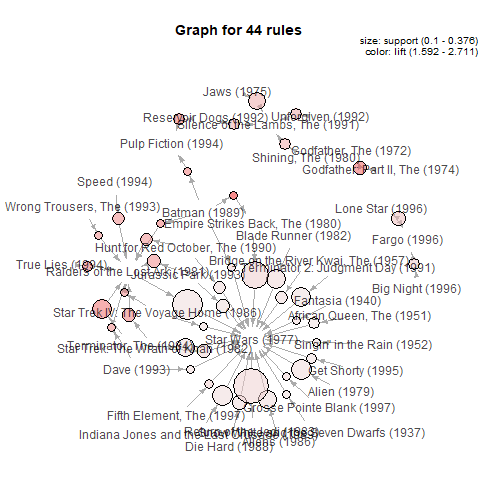

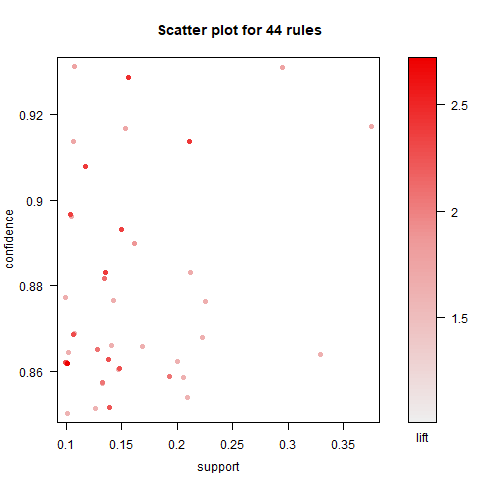

In [46]:
#执行以上语句，在tmp_results文件夹下生成arules_XXXX.png文件，然后再Jupyter中进行显示
from IPython.display import display, Image
rules_image_path = "tmp_results/arules_graph.png"
display(Image(filename=rules_image_path))

rules_image_path = "tmp_results/arules_support_conf_lift.png"
display(Image(filename=rules_image_path))

# 与其他方法的比较

In [47]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [48]:
%store -r ratings

In [49]:
ratings.columns

Index(['UserID', 'MovieID', 'Rating', 'Favorable', 'Title'], dtype='object')

In [50]:
rating_mtx_df = ratings.pivot_table(values='Rating',
                                   index='UserID',
                                   columns='Title',
                                   fill_value=0)

In [51]:
rating_mtx_df.head()

Title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,"Wooden Man's Bride, The (Wu Kui) (1994)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Year of the Horse (1997),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,0,2,5,0,0,3,4,0,0,...,0,5,0,0,5,3,0,0,0,4
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,2,0,0,0,0,4,0,0,...,0,5,0,0,4,0,0,0,0,4


In [52]:
recomm = TruncatedSVD(n_components=20, random_state=2012)
R = recomm.fit_transform(rating_mtx_df.values.T)

In [53]:
correlation_matrix = np.corrcoef(R)

In [54]:
correlation_matrix.shape

(1410, 1410)

In [55]:
rating_mtx_df.columns

Index([''Til There Was You (1997)', '1-900 (1994)', '101 Dalmatians (1996)',
       '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)',
       ...
       'Wooden Man's Bride, The (Wu Kui) (1994)', 'Wrong Trousers, The (1993)',
       'Wyatt Earp (1994)', 'Year of the Horse (1997)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Poisoner's Handbook, The (1995)',
       'Zeus and Roxanne (1997)', 'unknown'],
      dtype='object', name='Title', length=1410)

In [56]:
target_movie = '2001: A Space Odyssey (1968)'
target_movie = 'Gone with the Wind (1939)'
AN_index = list(rating_mtx_df.columns).index(target_movie)
AN_index

536

In [57]:
AN_P = correlation_matrix[AN_index]

In [58]:
AN_P

array([0.34959243, 0.00881404, 0.47861416, ..., 0.296343  , 0.22164689,
       0.12243906])

In [59]:
order_index = np.argsort(AN_P)[::-1]

In [60]:
rating_mtx_df.columns[order_index][:20]

Index(['Gone with the Wind (1939)', 'Breakfast at Tiffany's (1961)',
       'African Queen, The (1951)', 'Mr. Smith Goes to Washington (1939)',
       'Casablanca (1942)', 'My Fair Lady (1964)',
       'It's a Wonderful Life (1946)', 'Dial M for Murder (1954)',
       'Sound of Music, The (1965)', 'Cat on a Hot Tin Roof (1958)',
       'Roman Holiday (1953)', 'Wizard of Oz, The (1939)',
       'Singin' in the Rain (1952)', 'Streetcar Named Desire, A (1951)',
       'Citizen Kane (1941)', 'On Golden Pond (1981)',
       'Sense and Sensibility (1995)', 'Cinema Paradiso (1988)',
       'Snow White and the Seven Dwarfs (1937)',
       'Philadelphia Story, The (1940)'],
      dtype='object', name='Title')

当我们需要测试更多电影时，可以定义一个函数：

In [61]:
def movie_recom(target_movie, top_n=10):
    AN_index = list(rating_mtx_df.columns).index(target_movie)
    AN_P = correlation_matrix[AN_index]
    order_index = np.argsort(AN_P)[::-1]
    return rating_mtx_df.columns[order_index][:top_n]

In [62]:
movie_recom(target_movie='Star Wars (1977)')

Index(['Star Wars (1977)', 'Return of the Jedi (1983)',
       'Raiders of the Lost Ark (1981)', 'Empire Strikes Back, The (1980)',
       'Twelve Monkeys (1995)', 'Toy Story (1995)', 'Terminator, The (1984)',
       'Blade Runner (1982)', 'Independence Day (ID4) (1996)',
       'Star Trek: First Contact (1996)'],
      dtype='object', name='Title')

In [63]:
movie_recom(target_movie='Return of the Jedi (1983)')

Index(['Return of the Jedi (1983)', 'Star Wars (1977)',
       'Empire Strikes Back, The (1980)', 'Star Trek: First Contact (1996)',
       'Independence Day (ID4) (1996)', 'Rumble in the Bronx (1995)',
       'Raiders of the Lost Ark (1981)', 'Mission: Impossible (1996)',
       'Toy Story (1995)', 'Twelve Monkeys (1995)'],
      dtype='object', name='Title')

In [64]:
movie_recom(target_movie='Silence of the Lambs, The (1991)')

Index(['Silence of the Lambs, The (1991)', 'Pulp Fiction (1994)',
       'Usual Suspects, The (1995)', '2001: A Space Odyssey (1968)',
       'Jaws (1975)', 'Shawshank Redemption, The (1994)',
       'Forrest Gump (1994)', 'E.T. the Extra-Terrestrial (1982)',
       'One Flew Over the Cuckoo's Nest (1975)',
       'Raiders of the Lost Ark (1981)'],
      dtype='object', name='Title')

# 小结

在这个小实验中，只是利用Apriori这个最经典的算法，做了关联规则的一些初步尝试。为了提升效率，也可以尝试一下FP-Growth等方法，既可以自行写算法实现，也可以调用[mlxtend](http://rasbt.github.io/mlxtend)、[Orange-Associate](https://orange3-associate.readthedocs.io/en/latest/scripting.html)、pyspark等。<br>

---

关于电影推荐，除了关联规则之外，其他的一些经典算法，如协同过滤、基于二部图的推荐算法、基于奇异值分解SVD的推荐算法等，均值得进一步探讨。


# 课后练练手

本实验所演示的关联规则的挖掘，仅实现了一些最基础的功能，同学们课后可以进一步拓展：  
* 采用用户推荐的其他方法，比如协同过滤方法
* 采用关联规则的其他方法，比如FP-Growth
* 将电影名称翻译成中文
* 创建Arules类，采用面向对象的方法对本实验所涉及的代码进行改写